# CompSpec Infilteration

## Intro

* **Date**: 11/27/2020
* **What**: This is a [CompSpec](../../Reductionist%20Quasi-Isomorphisms/11_26_2020_experiment_comp_spec_mini_batch) network that filters the weight prototypes with the input before the dot product is calculated between the resultant vector and the input.  Aside from that, there isn't a huge change between this and my mini-batched CompSpec network.
* **Why**: By adding this "filtering mechanism," I'm giving my network far greater flexibility to respond to a greater range of structure in the data than is allowed currently.  Right now, the neurons essentially just try to find input prototypes that do a good job of spanning the dataset.  With filtering, each neuron would potentially be able to respond to a wide variety of inputs instead of just one prototypical input.  I don't want to get too excited to early, but this architecture hopefully also allows for the "or-gate" functionality, in which a neuron is able to respond to different types of inputs that are correlated to the same ground truth.  (I.e. "This, or this, or this is a 7. They're all different, but they're all sevens)
* **Hopes**: My humble hope is that either this architecture or a different architecture like it puts backprop into a grave. The reason why I think this architecture could potentially be so good is that I'm theorizing it will be able to both learn important structures, and be able to "understand" correlations between many different types of a thing and it's classification (many different types of sevens are all sevens).  I think that'll be the key unlocking god-tier performance on machine learning tasks.
* **Limitations**: When I tried something like this before, the weight prototypes got really messy, and didn't appear to converge to anything particularly useful.  However, back then, everything was failing and I didn't really have anything good to go off of.  I think if I try to do filtering in a CompSpec architecture, things might be different.  Especially because I'm utilizing spherical learning to add some level of constraint to the weight prototypes.  But I guess the only thing to it is to do it.  So let's do it.

## Technicals

Ok, so (unless I have to change them) the weight adjustment step and the competition value calculation are the same in this network as in the CompSpec mini batch architecture I already mentioned above.  The only thing that's different is how each neuron's output is calculated.  In the OG CompSpec mini batch, the (normalized) dot product between the weight prototype and the input vector was taken to be a neuron's output.  However, I found that kinda limiting, because all a certain neuron can represent is one prototype.  And, if you think about regular neurons, it's not a dot product between input and weights, it's kinda like an accumulation.  

So, the way I'm thinking about this is that it's only the synapses that are activated that really matter.  We can safely ignore what's happening in the other synapses, we only care about the ones that are most activated.  So then, the way I calculate the neuron output is to multiply the input vector by the weight vector element-wise, and then calculate the dot product between that resultant (normalized) vector and the input vector.  So, if $w$ is the weight vector, $q$ is the input vector, and $o$ is the neuron's output, we have:

$$
o = \frac{\left<wq, q\right>}{\sqrt{\left<wq, wq\right>\left<q, q\right>}}
$$

Where $\left|wq\right>$ represents the weight vector and input vector multiplied element-wise.  The reason why I'm keeping the update rule the same is because first of all, I really like the weight vector being constrained to the unit sphere, and also because I want it learning to ignore the parts of the image that don't matter.  We'll see if this works out, and if it doesn't, then shit, I guess we'll have to change it.

Alright, let's get this code.

## Code

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from time import time
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

L = 28 * 28   #Size of mnist in pixels
S = 60000     #Size of training set

(train_X, train_y), (test_X, test_y) = mnist.load_data()
train_X = train_X / 255.0

flat_x = np.reshape(train_X, [-1, L])
flat_test = np.reshape(test_X, [-1, L])

In [9]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()   

In [10]:
def wta_classification(w, T_s):
    flat_x = np.reshape(train_X, [-1, L])
    flat_test = np.reshape(test_X, [-1, L])
    
    v = flat_x[:T_s]
    train_lbls = train_y[:T_s]
    
    v = v / np.array([np.linalg.norm(v, axis=1)]).T
    w = w / np.array([np.linalg.norm(w, axis=1)]).T
    
    wins = np.argmax(w @ (flat_x[:T_s, :]).T, axis=0)
    
    n_wins = np.zeros((w.shape[0], 10))
    
    for (n_i, lbl) in zip(wins, train_lbls):
        n_wins[n_i][lbl] += 1
        
    n_cls = np.argmax(n_wins, axis=1)
    print("Neuron classes:", n_cls)
    
    num_test = test_y.shape[0]
    test_v = flat_test / np.array([np.linalg.norm(flat_test, axis=1)]).T
    
    num_correct = 0
    
    incorrect = np.zeros(10)
    
    for i in range(num_test):
        w_mul_v = w @ test_v[i].T
        
        n_max = np.argmax(w_mul_v)
        
        pre = n_cls[n_max]
        if pre == test_y[i]:
            num_correct += 1
        else:
            incorrect[test_y[i]] += 1
            
    print("Accuracy:", str(num_correct * 100 / num_test) + '%')
    print("Misclassifieds: ", incorrect)
        

In [38]:
"""
flat_x: training data
S: Size of training set
L: Size of input
Kx: Num cols of neurons
Ky: Num rows of neurons
Nep: Num epochs
T_s: Number of training inputs
xi: Base learning constant
phi: Specialization ema constant
B: Batch size
prec: The smallest value allowed for the norm of the filtered weight vector

Returns: (synapse_weights, neuron specialization values)
"""
def comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec):
    start = time()
    N = Kx * Ky
    
    w = np.abs(np.random.normal(0, 1, (N, L))) # synapses of each neuron
    w = w / np.array([np.linalg.norm(w, axis=1)]).T #NORMALIZE THE WEIGHTS TO PREVENT EXXXPLOSIONS
    s = np.zeros(N).reshape(-1, 1) # Specialization for each neuron+

    for ep in range(Nep):
        inputs = flat_x[np.random.permutation(S), :]
        in_sq = np.square(inputs)
        in_norm = np.linalg.norm(inputs, axis=1)
        
        for i in tqdm(range(T_s // B)):
            v = inputs[i * B: (i + 1) * B]
            v_sq = in_sq[i * B: (i + 1) * B].T #Automatically transpose
            v_norm = in_norm[i * B: (i + 1) * B]
        
            wv_v = w @ v_sq
            
            wv_wv_norm = np.sqrt(np.maximum(np.square(w) @ v_sq, prec))
        
            o = wv_v / (wv_wv_norm * v_norm)
        
            w_mul_v = w @ v.T 
            
            c = (1 - s) / (1 - o)

            wins = np.argmax(c, axis=0)     

            win_mask = np.zeros((N, B))
            win_mask[wins, np.arange(B)] = 1
            win_mask = (win_mask / np.maximum(np.sum(win_mask, axis=1), 1).reshape(-1, 1))

            win_avg = (np.sum(w_mul_v * win_mask, axis=1)).reshape(-1, 1)

            v_update = win_mask @ v

            del_syn = (v_update - (win_avg * w)) * (((1 - s) ** 2) + 0.1) * xi

            w += del_syn

            s[wins] *= (1 - phi)
            s += phi * np.sum(o * win_mask, axis=1).reshape(-1, 1)

        draw_weights(w, Kx, Ky)

    print("Max val: ", np.amax(s), "Min value: ", np.amin(s), "Mean val: ", np.mean(s), "Std: ", np.std(s))
    print("Elapsed time: ", time() - start, " seconds")
    
    return (w, s)

## Analysis Dialog

Well fam, everything seems to be working nicely.  At least from the perspective of handwritten digits.  It looks like it's about twice as slow as the original, but I'm ok with that, given that I think this computation allows for correlation of information far more than the OG mini-batched CompSpec.  I think I'll just show you the outputs from the network for a variety of different neuron counts.  

Like I said before, I'm not really trying to pass this through any metrics at the moment, but I'll also include a wta_classification accuracy just to show you that everything hasn't gone to shit.  I'm also going to do a wider variety of neuron counts, just so you can see what things look like at different levels.  It'll be *really* interesting to hook this into a correlated classifier with a bunch of different neuron counts.  That's pretty exciting, but I shouldn't get excited before I see it work.  

Ok, here you go:

100%|██████████| 6000/6000 [00:00<00:00, 6859.81it/s]


Max val:  0.9830045793977528 Min value:  0.9451538747116083 Mean val:  0.971001866117828 Std:  0.010126688886090049
Elapsed time:  1.4730620384216309  seconds



Neuron classes: [1 0 7 8 1 7 1 3 6 1]
Accuracy: 39.43%
Misclassifieds:  [ 110.   10. 1032.  824.  982.  892.  357.  272.  569. 1009.]


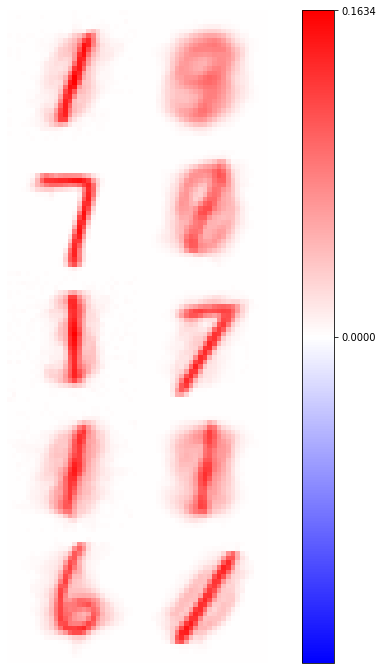

In [30]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 2
Ky = 5
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 10 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 1200/1200 [00:00<00:00, 1368.80it/s]


Max val:  0.986829081352881 Min value:  0.9426209636437128 Mean val:  0.9735150938221292 Std:  0.008607402684604382
Elapsed time:  1.4500977993011475  seconds



Neuron classes: [8 3 1 4 1 1 6 6 1 3 2 1 9 7 9 2 2 1 8 7 6 6 1 8 0]
Accuracy: 52.86%
Misclassifieds:  [442.  72. 155. 667. 845. 892. 111. 504. 676. 350.]


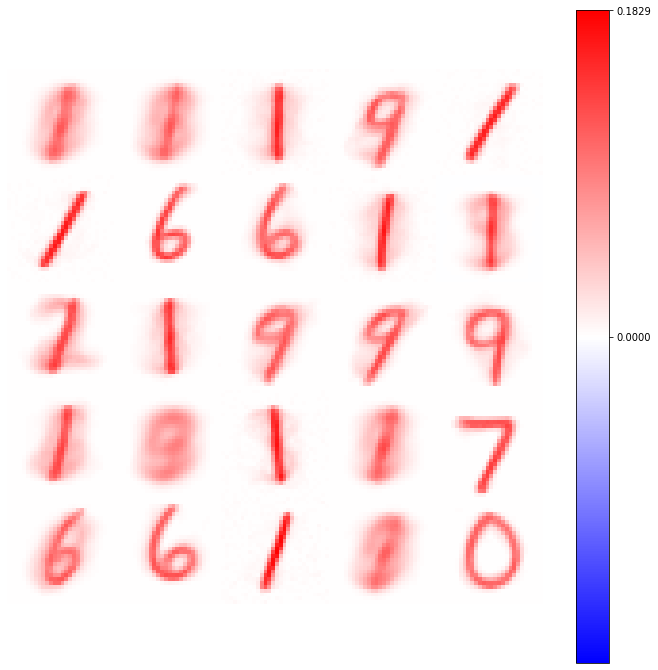

In [31]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 5
Ky = 5
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 50 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 600/600 [00:00<00:00, 656.47it/s]


Max val:  0.9892451886555143 Min value:  0.8922309994285327 Mean val:  0.9707606578666723 Std:  0.013345278483625659
Elapsed time:  1.4854815006256104  seconds



Neuron classes: [3 1 2 7 4 6 1 7 6 4 7 2 9 2 1 3 9 1 7 1 7 7 6 1 9 5 1 1 8 1 1 9 6 9 7 8 8
 4 7 1 1 8 1 6 9 2 1 8 1 4 5 2 7 9 6 1 4 0 2 6 7 1 7 7]
Accuracy: 60.59%
Misclassifieds:  [125.  64. 744. 467. 456. 506. 116. 192. 720. 551.]


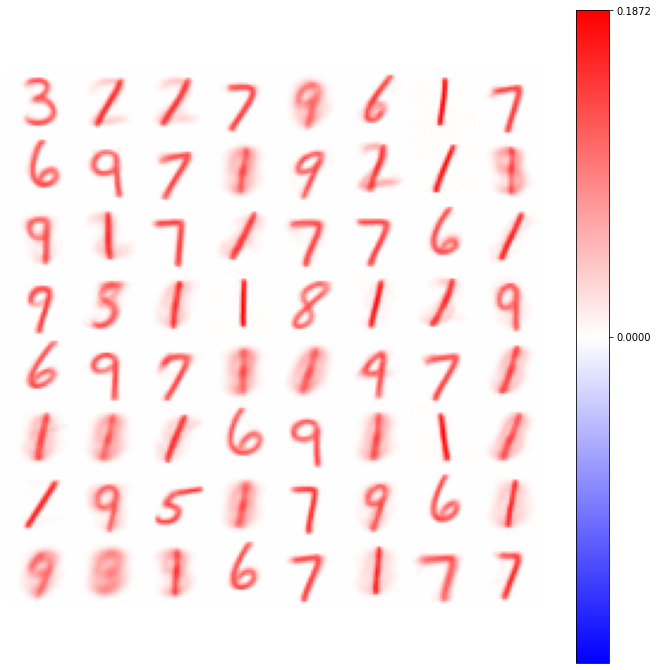

In [32]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 8
Ky = 8
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 100 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 600/600 [00:01<00:00, 500.50it/s]


Max val:  0.9883580212124954 Min value:  0.9206961382076969 Mean val:  0.968326397197164 Std:  0.012240202096643605
Elapsed time:  1.7742629051208496  seconds



Neuron classes: [1 9 1 1 1 2 7 1 0 9 7 6 0 6 8 1 2 1 1 0 9 3 6 3 2 8 2 5 4 1 8 2 8 1 6 7 3
 4 7 0 9 8 5 7 6 1 9 8 3 2 8 9 9 9 4 1 9 7 7 7 7 1 7 1 5 4 7 6 7 7 3 8 0 2
 0 7 4 1 6 1 1 7 9 4 5 8 3 7 1 7 1 7 0 1 7 1 1 9 3 1]
Accuracy: 75.95%
Misclassifieds:  [ 99.  29. 294. 200. 401. 384. 168. 183. 328. 319.]


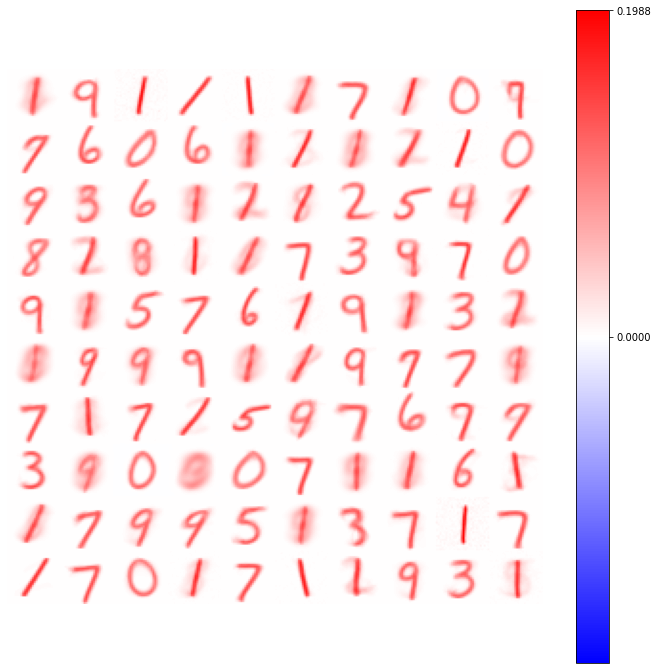

In [34]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 100 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 300/300 [00:03<00:00, 77.84it/s]


Max val:  0.9880602118012813 Min value:  0.8871761128161828 Mean val:  0.9592257076901598 Std:  0.01272831955867799
Elapsed time:  4.439465761184692  seconds



Neuron classes: [8 0 7 7 5 3 1 6 5 9 6 2 0 1 1 6 0 5 1 2 5 4 7 2 7 6 9 7 2 0 6 5 7 1 7 1 0
 7 1 1 2 1 9 3 0 7 1 1 1 9 9 9 4 4 4 9 3 1 7 6 0 7 2 7 3 6 6 6 8 3 1 9 9 2
 1 2 1 1 7 4 7 5 6 7 7 4 1 3 2 3 8 9 3 0 7 3 1 1 7 9 6 7 7 1 6 4 1 7 4 7 0
 6 1 3 3 6 8 1 0 9 7 1 0 6 9 7 0 9 3 7 9 6 9 7 9 2 6 1 9 4 4 6 4 7 5 4 1 2
 1 3 6 9 1 1 7 2 5 5 5 9 1 0 7 3 2 4 7 1 8 5 2 4 7 0 8 4 9 6 4 7 7 1 1 2 2
 0 1 7 3 7 6 4 7 3 8 7 5 7 1 3 3 2 2 0 3 8 5 7 6 5 4 7 9 1 3 2 3 1 7 2 0 3
 6 0 7 4 5 1 6 5 7 9 3 3 0 1 5 1 9 6 1 6 2 3 3 6 5 0 0 7 3 2 4 7 1 7 7 1 2
 1 9 1 7 4 1 9 0 0 1 7 1 9 3 6 3 2 7 6 5 6 8 4 0 1 9 7 8 4 5 3 6 0 8 3 9 7
 7 6 1 1 6 1 1 4 9 5 4 9 3 0 9 2 6 1 1 9 0 0 7 6 6 1 1 1 8 3 2 4 3 3 7 3 2
 4 4 4 2 6 2 0 5 5 6 0 7 5 0 3 7 0 1 9 4 2 7 6 1 4 6 0 0 7 5 3 0 4 6 0 8 5
 7 7 2 5 5 2 9 0 0 0 9 2 8 1 1 9 1 3 5 4 5 9 7 1 9 1 4 7 2 2]
Accuracy: 8

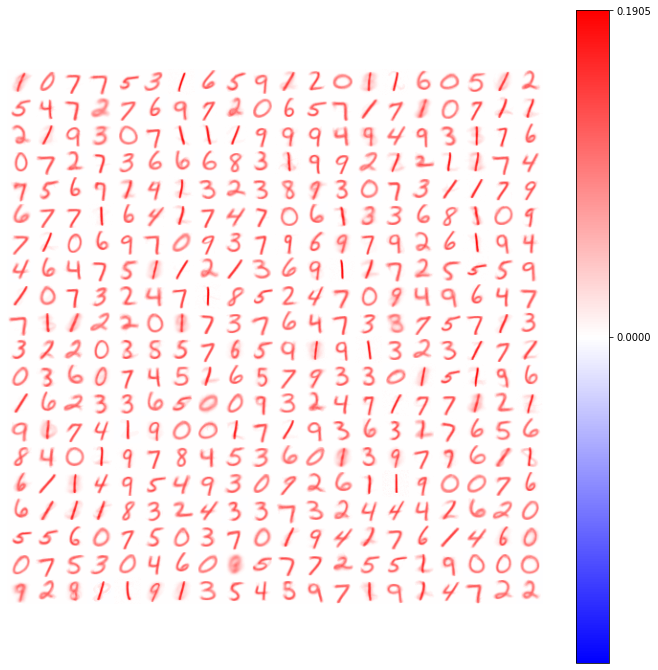

In [35]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 20
Ky = 20
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

100%|██████████| 300/300 [00:18<00:00, 15.93it/s]


Max val:  0.9674538091776778 Min value:  0.49688291200783125 Mean val:  0.8082937376727263 Std:  0.07134291806226292
Elapsed time:  19.566429376602173  seconds



Neuron classes: [8 6 4 ... 9 6 2]
Accuracy: 91.01%
Misclassifieds:  [ 44.  19.  84.  97. 153.  82.  30.  91. 179. 120.]


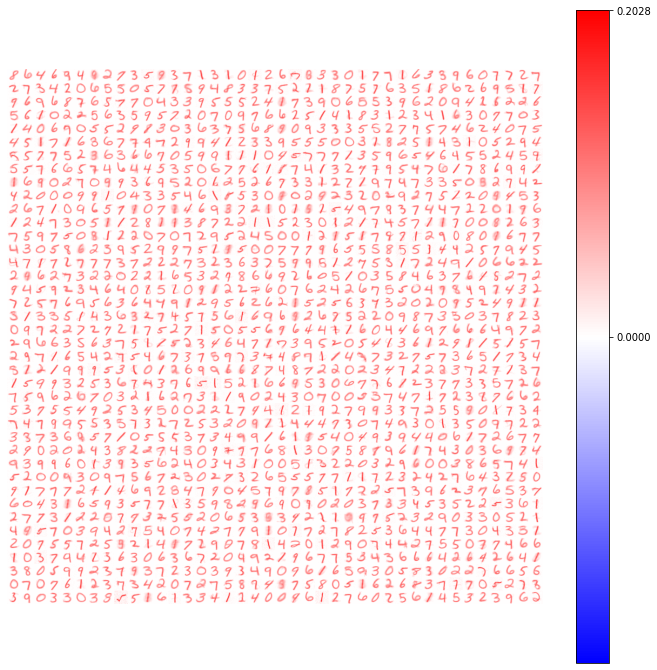

In [36]:
%matplotlib inline
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 40
Ky = 40
Nep = 1
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 200 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Alright, sweet!  So there are a couple things here that I'd like to discuss.  

First things first, we're still seeing coherent prototypes, which is pretty fantastic.  The last time I did something like this, the inputs ended up being this weird soup.  However, back then (literally in AZ I think, so like three weeks ago), I was using a shit base level algorithm.  It was like averaged wta.  God I hate weighted averages.  I really learned to hate weighted averages.  Let the inputs fight like real men.  

I'd also like to mention that I can pick out a fuzzy three in basically all the networks above.  Typically I get nervous about fuzzy threes, but here I'm actually down with them because it provides a sort of "catch-all" neuron that hopefully will be activated by a lot of different inputs, but only to a certain degree.

Now then, here's the thing that's super cool about this network.  If you look carefully at all the weight prototypes, you'll see some that look mostly like a 1, but you can also see the ghost of a 2, 3, or even 4 behind it.  This is *really really awesome.* Why? Because these two different types of inputs share the structure of the 1, and that's reflected in the prototype. Why is the 1 part so much stronger than the 2 part?  Because that's the structure that's shared.  If you think about how the weights are updated, the one part is boosted for both type of input, whereas then the input is a 1, the other parts of the structure are weakened.  However, they still are there, which indicates that the network is still picking them up.  

Whelp, that's about all I have to say about this network.  I guess the only worry I would have about this architecture is that it's volatile when it's fed different inputs.  There isn't a really good way to show this, but run the following code and watch how the weights change between epochs.

<IPython.core.display.Javascript object>


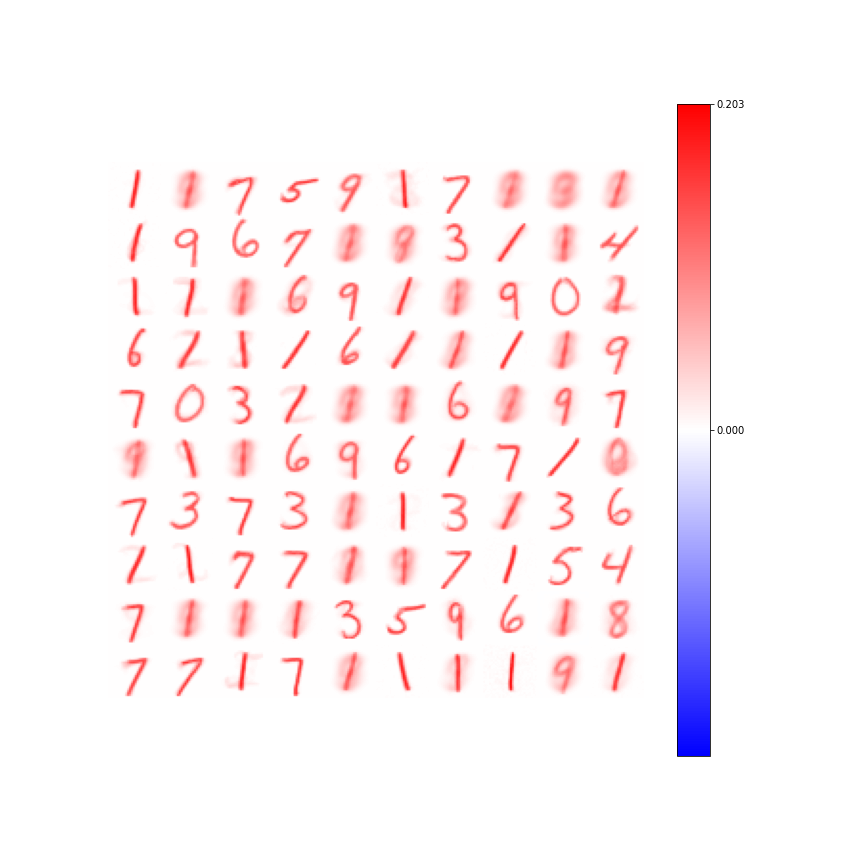

100%|██████████| 600/600 [00:01<00:00, 489.79it/s]


Max val:  0.9898838211511829 Min value:  0.9434321685285617 Mean val:  0.9775008278347687 Std:  0.00750435830423485
Elapsed time:  19.71484065055847  seconds



Neuron classes: [1 8 7 5 9 1 7 2 2 8 1 9 6 7 8 8 3 1 8 4 1 1 8 6 9 1 8 9 0 2 6 2 1 1 6 1 8
 1 8 9 7 0 3 1 8 3 6 8 9 7 7 1 8 6 4 6 1 7 1 2 7 3 7 3 1 1 3 1 3 6 1 1 7 7
 8 7 7 1 5 4 7 8 2 1 3 5 4 6 8 8 7 7 1 7 4 1 1 1 4 1]
Accuracy: 65.84%
Misclassifieds:  [314.  59. 231. 377. 430. 670. 265. 266. 332. 472.]


<IPython.core.display.Javascript object>


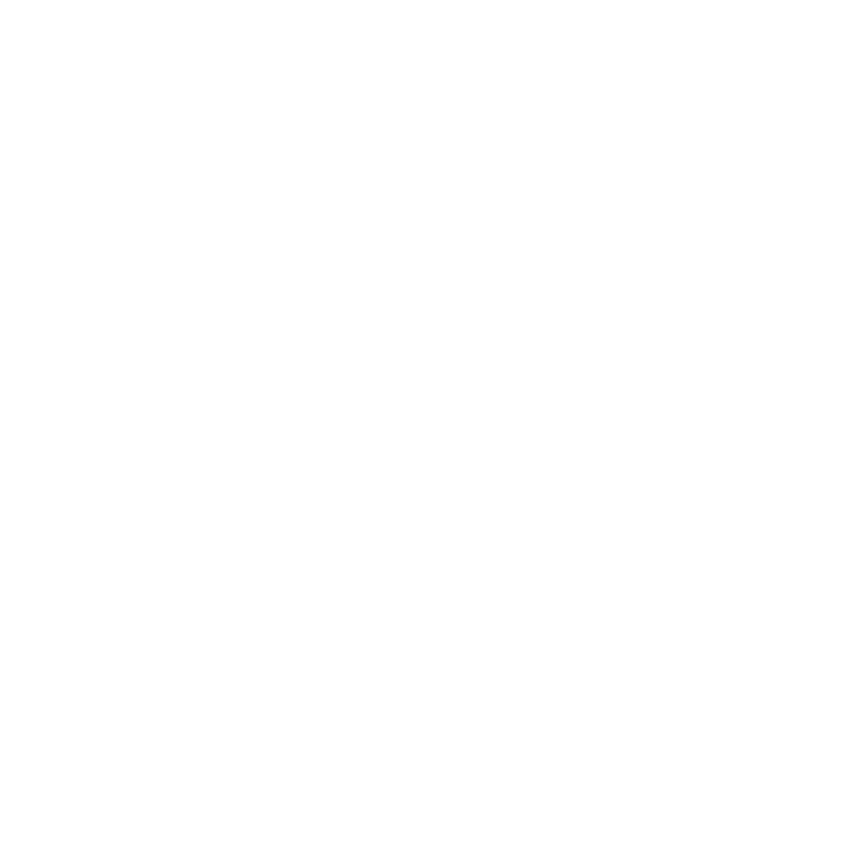

In [50]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 100 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

With the above setup, it took about 5-7 epochs, but eventually the prototypes don't change at all.  I should also mention that after the second epoch, barely any of the weight prototypes changed.  I'm also going to do this for a smaller, and then a larger network and see what happens.

<IPython.core.display.Javascript object>


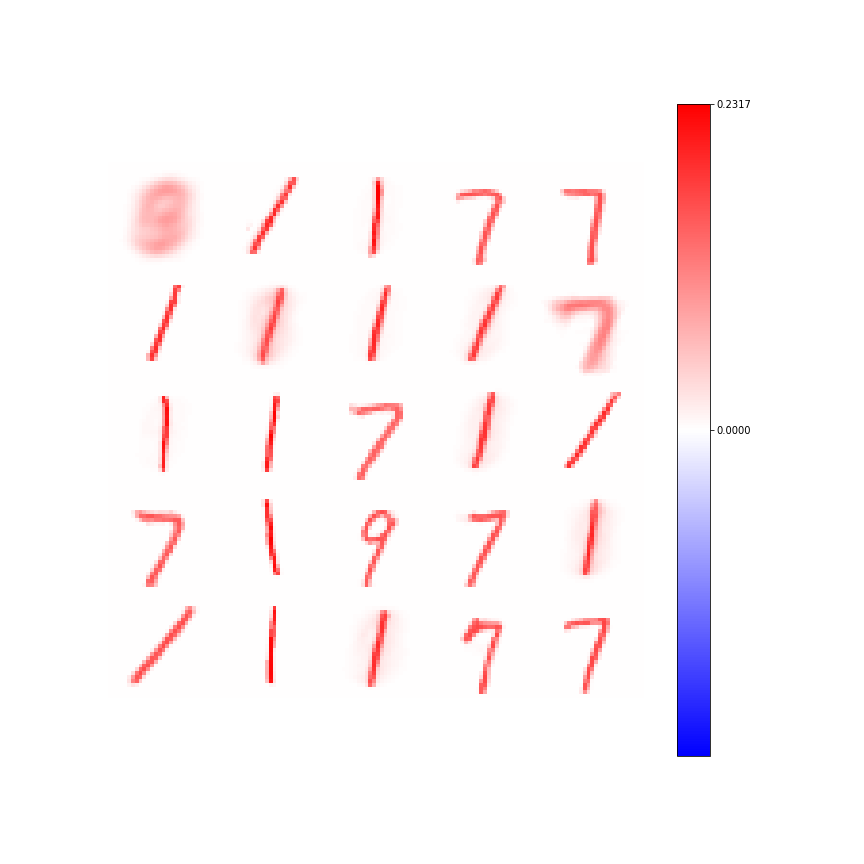

100%|██████████| 1200/1200 [00:01<00:00, 1170.44it/s]


Max val:  0.9728213858767147 Min value:  0.9217422314947487 Mean val:  0.9587800099802152 Std:  0.011675302803234087
Elapsed time:  50.09110426902771  seconds



Neuron classes: [0 1 1 7 7 1 1 1 1 7 1 1 7 1 1 7 1 9 7 1 1 1 1 9 7]
Accuracy: 30.24%
Misclassifieds:  [   4.   25. 1032. 1010.  982.  892.  958.  194.  974.  905.]


<IPython.core.display.Javascript object>


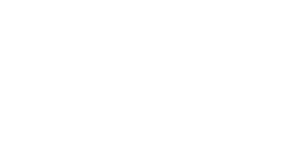

In [59]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 5
Ky = 5
Nep = 30
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 101

B = 50 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

Ok, this network basically only changed through the epochs if I lowered the specialization ema.  I guess that's something that could cause trouble.  With the low ema, these neurons basically stopped changing after like 1-3 epochs. I think the neurons latch onto particular prototypes very quickly, the rest of the inputs are subsumed by the fuzzy three. Poor guy. Taking the brunt of everything.  You know what?  This network might actually learn better if the data isn't shuffled!  That's wild.  Because then, there'd be no fuzzy three.  Wow!  And, I mean, that's how our brains take in information anyway.  

I'll need to try that out.

<IPython.core.display.Javascript object>


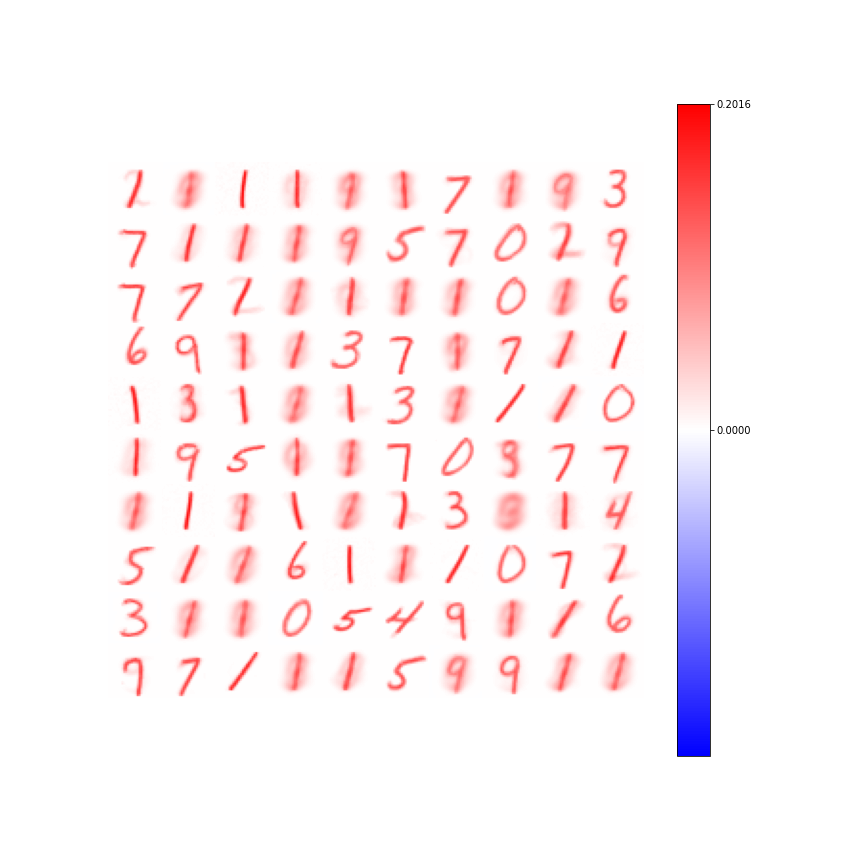

100%|██████████| 600/600 [00:01<00:00, 477.02it/s]


Max val:  0.9901418439469424 Min value:  0.9408756445728079 Mean val:  0.9780912024340408 Std:  0.007533023944837643
Elapsed time:  19.76656675338745  seconds



Neuron classes: [1 8 1 1 2 1 7 8 8 3 7 1 1 8 9 5 7 0 2 9 7 7 1 2 1 8 8 0 8 6 6 9 3 4 3 7 8
 7 1 1 1 3 1 8 1 3 3 1 1 0 1 9 5 2 8 7 0 3 7 7 8 1 7 1 8 1 3 2 1 4 5 1 2 6
 1 8 1 0 7 1 3 4 2 0 5 4 9 8 1 6 7 7 1 2 1 5 4 9 8 2]
Accuracy: 64.59%
Misclassifieds:  [223.  31. 299. 234. 595. 565. 325. 237. 629. 403.]


<IPython.core.display.Javascript object>


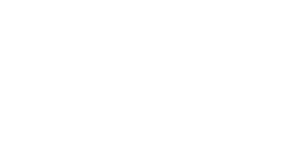

In [45]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12,12))

mu = 0
sig = 1
Kx = 10
Ky = 10
Nep = 10
T_s = 60000
xi = 0.1
theta = 2 / 17
phi = 2 / 11

B = 100 #Batch size

prec = 0.01

(w, _) = comp_spec_infilter(flat_x, S, L, Kx, Ky, Nep, T_s, xi, phi, B, prec)
print("\n\n")
wta_classification(w, T_s)
draw_weights(w, Kx, Ky)

In [28]:
np.argmin(_)

31

In [15]:
a

array([[1., 1.],
       [1., 1.]])

In [18]:
np.maximum(a, 2)

array([[2., 2.],
       [2., 2.]])